### pip install & import

In [13]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder


# 데이터 준비

### 최종데이터 불러오기
- movie_resize_회귀 : 전국 관객수 10000명 초과, 관객수 100000 미만 전국 스크린수 50 초과   

In [54]:
movie_final_회귀 = pd.read_csv('../3_merge_top300/movie_final_reg.csv',encoding='utf-8')

### 스케일링

In [55]:
# '전국 스크린수'와 '총 관객수' 데이터 스케일링: RobustScaler()사용

robust_scaler = RobustScaler()

A_n = robust_scaler.fit_transform(movie_final_회귀['전국 스크린수'].values.reshape(-1,1))
movie_final_회귀.insert(0, '전국 스크린수_1', A_n)
movie_final_회귀.drop(['전국 스크린수'], axis=1, inplace=True)

A_n1 = robust_scaler.fit_transform(movie_final_회귀['총 관객수'].values.reshape(-1,1))
movie_final_회귀.insert(0, '총 관객수_1', A_n1)
movie_final_회귀.drop(['총 관객수'], axis=1, inplace=True)

movie_final_회귀.columns


Index(['총 관객수_1', '전국 스크린수_1', 'Unnamed: 0', '순번', '영화명', '감독', '배급사', '개봉일',
       '영화형태', '국적', '전국 매출액', '전국 관객수', '서울 매출액', '서울 관객수', '장르', '등급',
       '영화구분', '연도', '월', '계절', '코로나', '출연', '평점', '감독_흥행', '배급사_흥행',
       '주연배우_흥행'],
      dtype='object')

### 라벨링

In [56]:
# 명목형 자료들을 라벨링: LabelEncoder() 사용

le_form = LabelEncoder()
le_nation = LabelEncoder()
le_genre = LabelEncoder()
le_rating = LabelEncoder()
le_class = LabelEncoder()
le_season = LabelEncoder()

movie_labels = movie_final_회귀.copy()
movie_labels['영화형태'] = le_form.fit_transform(movie_final_회귀['영화형태'])
movie_labels['국적'] = le_nation.fit_transform(movie_final_회귀['국적'])
movie_labels['장르'] = le_genre.fit_transform(movie_final_회귀['장르'])
movie_labels['등급'] = le_rating.fit_transform(movie_final_회귀['등급'])
movie_labels['영화구분'] = le_class.fit_transform(movie_final_회귀['영화구분'])
movie_labels['계절'] = le_season.fit_transform(movie_final_회귀['계절'])
movie_labels.drop(['Unnamed: 0'],axis=1,inplace=True)
movie_labels.head(3)

,총 관객수_1,전국 스크린수_1,순번,영화명,감독,배급사,개봉일,영화형태,국적,전국 매출액,...,영화구분,연도,월,계절,코로나,출연,평점,감독_흥행,배급사_흥행,주연배우_흥행
0,0.018839,1.959732,2575,미니특공대X,이영준,삼지애니메이션,2018-03-22,2,7,744858200,...,1,2018,3,2,0,"['엄상현', '전태열', '이소영', '신용우']",7.55,0,0,0
1,-0.854008,-0.033557,2578,알파독,닉 카사베츠,싸이더스,2009-01-29,2,2,648950794,...,1,2009,1,1,0,"['에밀 허쉬', '저스틴 팀버레이크', '벤 포스터', '안톤 옐친', '아만다 ...",6.06,0,6,6
2,-1.463612,3.348993,2583,엘비스,바즈 루어만,워너브러더스 코리아,2022-07-13,2,2,1070700628,...,1,2022,7,3,1,"['오스틴 버틀러', '톰 행크스']",8.83,0,10,5


### 데이터 및 변수 정리

#### 1) 데이터 재분배
1) movie_labels_etc : train과 val data   
2) movie_labels_2023 : test data

In [57]:
# 2003년~2022년 데이터와 2023년 데이터로 나눔
movie_labels_etc = movie_labels[movie_labels['연도']!=2023]
movie_labels_2023 = movie_labels[movie_labels['연도']==2023]

#### 2) 독립 및 종속 변수 선언

In [58]:
# 사용하지 않는 컬럼 제거

not_used = ['영화명', '감독', '배급사', '영화형태', '개봉일', '영화구분', '월']

movie_DL = movie_labels_etc.drop(not_used, axis=1) # 2003~2022 데이터 main
movie_DL2 = movie_labels_2023.drop(not_used, axis=1) # 2023년 test

In [59]:
# 독립 변수와 종속 변수 나눔

종속 = movie_DL[['전국 관객수']].copy()
종속['전국 관객수'] = 종속['전국 관객수'] / 1000 

종속_2023 = movie_DL2[['전국 관객수']].copy()
종속_2023['전국 관객수'] = 종속_2023['전국 관객수'] / 1000 


독립 = movie_DL[['장르', '등급', '감독_흥행','총 관객수_1',
               '배급사_흥행','주연배우_흥행','계절', '전국 스크린수_1','코로나']].copy()

독립_2023 = movie_DL2[['장르', '등급', '감독_흥행','총 관객수_1',
               '배급사_흥행','주연배우_흥행','계절', '전국 스크린수_1','코로나']].copy()

#### 3) train, validation용 데이터 나누기

In [60]:
# train, validation 데이터 나눔

from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(독립,종속,test_size=0.25, random_state=42)

# 모델 구조 만들기


In [61]:
# 딥러닝 층 여기가 중요

X = tf.keras.layers.Input(shape=[len(train_input.columns)])

H = tf.keras.layers.Dense(90)(X)
H = tf.keras.layers.BatchNormalization(epsilon=1e-5)(H)
H = tf.keras.layers.Activation(tf.nn.swish)(H)
# dropout = tf.keras.layers.Dropout(rate=0.2)(H)

H = tf.keras.layers.Dense(90)(H)
H = tf.keras.layers.BatchNormalization(epsilon=1e-5)(H)
H = tf.keras.layers.Activation(tf.nn.swish)(H)
# dropout = tf.keras.layers.Dropout(rate=0.2)(H)

H = tf.keras.layers.Dense(90)(H)
H = tf.keras.layers.BatchNormalization(epsilon=1e-5)(H)
H = tf.keras.layers.Activation(tf.nn.swish)(H)
dropout = tf.keras.layers.Dropout(rate=0.2)(H)

Y = tf.keras.layers.Dense(1)(dropout)
model = tf.keras.models.Model(X,Y)

Adagrad = tf.keras.optimizers.Adagrad(learning_rate=0.9,  epsilon=1e-6)
model.compile(optimizer=Adagrad,loss='mae')

# 모델 학습시키기

In [ ]:
# 훈련
history = model.fit(train_input,train_target,batch_size=128,epochs=100,validation_data=(val_input,val_target))

# 모델을 이용하기

### 손실값 그래프 확인

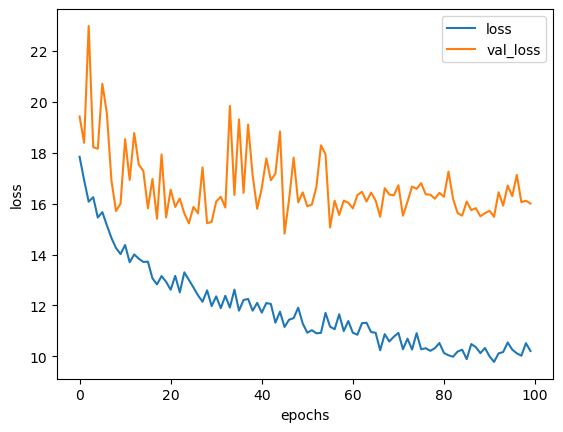

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

### test 세트로 모델 predict 수행

In [67]:
# 오차율 20%이내인 데이터 갯수 확인하기
pred = model.predict(독립_2023).round(0)

종속_2023['pred'] = pred
종속_2023['오차율'] = (abs(종속_2023['전국 관객수'] - 종속_2023['pred'])) / 종속_2023['전국 관객수'] * 100
len(종속_2023.loc[종속_2023['오차율']<20])

1/1 [==============================] - 0s 78ms/step


13

In [69]:
종속_2023[:5]

,전국 관객수,pred,오차율
56,92.369,105.0,13.674501
58,91.833,55.0,40.108676
68,90.281,84.0,6.957167
77,88.489,69.0,22.024206
358,54.192,53.0,2.199587


### 모델 저장 및 불러오기

In [62]:
# model.save("reg_model.h5")
model = tf.keras.models.load_model('../../../main/4_deepLearning/reg_model.h5',compile=False)